## Install packages

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install -r requirements.txt

## Load packages

In [2]:
# Useful packages
import os
import warnings

# Work with Python array and graphs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Cluster tendency
from pyclustertend import hopkins

# MVMDS
from sklearn.metrics import pairwise_distances
from multiview.mvmds import mvmds

# Clustering algorithm
from sklearn.cluster import KMeans

# Clustering performance evaluation
from sklearn.metrics import davies_bouldin_score, silhouette_score

## Load data

In [3]:
# Load matrices from CSV files
ISC_EEG = np.genfromtxt(os.path.join('ISC_EEG.csv'),delimiter=',')
ISC_EEG = np.array(ISC_EEG,dtype='float') # Convert into array

ISC_EDA = np.genfromtxt(os.path.join('ISC_EDA.csv'),delimiter=',')
ISC_EDA = np.array(ISC_EDA,dtype='float') # Convert into array

ISC_IBI = np.genfromtxt(os.path.join('ISC_IBI.csv'),delimiter=',')
ISC_IBI = np.array(ISC_IBI,dtype='float') # Convert into array

# Remove Inf in data for EDA and IBI (try to have similar ratio as in EEG between diagonal and mean non-diagonal)
tmp_EEG = np.copy(ISC_EEG)
tmp_EDA = np.copy(ISC_EDA)
tmp_IBI = np.copy(ISC_IBI)

for i in range(len(tmp_EEG)):
    tmp_EEG[i,i] = 0
    tmp_EDA[i,i] = 0
    tmp_IBI[i,i] = 0
eegNorm = np.max(ISC_EEG)/np.mean(tmp_EEG)

for i in range(len(ISC_IBI)):
    ISC_IBI[i,i] = np.mean(tmp_IBI)*eegNorm
    ISC_EDA[i,i] = np.mean(tmp_EDA)*eegNorm

## Compute distance matrix

In [4]:
def computeDistanceMatrix(study_matrix):
    
    # Normalise maximum value to 1
    normed_matrix = np.copy(study_matrix)
    normed_matrix = normed_matrix / np.max(abs(normed_matrix))
    
    # Convert into distance matrix
    distance_matrix = np.sqrt((1-normed_matrix)) # Formula in Matlab and in Scikit to convert 
        
    # Interval MDS normalization to spread values between 0 and 1
    a = np.min(np.sort(distance_matrix,axis=0)[1,:])
    distance_matrix = distance_matrix - a
    distance_matrix = distance_matrix - np.diag(np.diag(distance_matrix))
    distance_matrix = distance_matrix / np.max(distance_matrix)
    
    # To make sure output is perfectly symmetrical
    return (distance_matrix+distance_matrix.T)/2

## Multiview mapping

In [5]:
def computeAllDistanceMatrix(ISC_EEG,ISC_EDA,ISC_IBI):
    
    # Make copy of 3 matrices (for each modality)
    mat_EEG = np.copy(ISC_EEG)
    mat_EDA = np.copy(ISC_EDA)
    mat_IBI = np.copy(ISC_IBI)
    
    # Compute the 3 distance matrices (according to each modality)
    distance_matrix_EEG = computeDistanceMatrix(ISC_EEG)
    distance_matrix_EDA = computeDistanceMatrix(ISC_EDA)
    distance_matrix_IBI = computeDistanceMatrix(ISC_IBI)
  
    # Remove direct correlation influence and compute correlation distance matrices
    for i in range(len(ISC_EEG)):
        mat_EEG[i,i] = 0
        mat_EDA[i,i] = 0
        mat_IBI[i,i] = 0
    distance_matrix_corr_EEG = pairwise_distances(mat_EEG,metric='correlation')
    distance_matrix_corr_EDA = pairwise_distances(mat_EDA,metric='correlation')
    distance_matrix_corr_IBI = pairwise_distances(mat_IBI,metric='correlation')

    # Return distance matrices
    return distance_matrix_EEG, distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EEG, distance_matrix_corr_EDA, distance_matrix_corr_IBI

In [6]:
def computeMVMDSCoordinate(mat=['EEG','EDA','IBI','corrEEG','corrEDA','corrIBI']):

    # Compute all distance matrices
    distance_matrix_EEG, distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EEG, distance_matrix_corr_EDA, distance_matrix_corr_IBI = computeAllDistanceMatrix(ISC_EEG,ISC_EDA,ISC_IBI)    

    # Choose which matrices to include into the multiview
    multiviewMat = []
    if ('EEG' in mat):
        multiviewMat.append(distance_matrix_EEG)
    if ('EDA' in mat):
        multiviewMat.append(distance_matrix_EDA)
    if ('IBI' in mat):
        multiviewMat.append(distance_matrix_IBI)
    if ('corrEEG' in mat):
        multiviewMat.append(distance_matrix_corr_EEG)
    if ('corrEDA' in mat):
        multiviewMat.append(distance_matrix_corr_EDA)
    if ('corrIBI' in mat):
        multiviewMat.append(distance_matrix_corr_IBI)
        
    # Computing multiview mapping
    points = mvmds(multiviewMat,len(mat)*[True],2)
    
    return points

## Compute clustering

In [38]:
class Results():

    def __init__(self,mat):
        self.mat = mat
        
    def twoClustersMethodResult(self):
        print("Blind results\n")
        
        # Cluster tendency
        print("Hopkins test")
        self.hopkinsCoef()
        print("%f +- %f" %(self.hopkins[0],self.hopkins[1]))
        
        # Found clusters
        print("Found clusters ")
        print(self.label)
        
        # Clustering quality evaluation
        print("Silhouette coefficient : %0.3f" %self.silhouetteCoef())
        print("DB index : %f " %self.dbScore())
        
        # Comparing to ground truth (if known)
        if (os.path.isfile(os.path.join('condition.csv'))):
            global groundTruth
            if (groundTruth):
                print("\n\nComparing to ground truth\n")
                print("Accuracy : %f " %self.accuracy())
                print("Misclassified participants : [%s]" % ", ".join(map(str, self.misClassified)))        
        
    def applyMethod(self,method):
        
        # Mapping
        points = computeMVMDSCoordinate(self.mat)

        # Clustering
        meth = method.fit(points)

        # Store found labels and points location
        if hasattr(meth, 'labels_'):
            label = meth.labels_
        else:
            label = meth.predict(points)
        self.label = label
        self.best_points = points
         
    def showResultMap(self):
        
        # Set new figure
        plt.figure()
        ax = plt.axes([0,0,1.2,1.2])
        ax.set_aspect(aspect='equal')
        
        # Annotate points
        for i in range(len(ISC_EEG)):
            ax.annotate(i,(self.best_points[i,0],self.best_points[i,1]),xytext=(self.best_points[i,0]+(np.max(self.best_points[:,0])-np.min(self.best_points[:,0]))/50,self.best_points[i,1]))     
        
        # Show color according to trueDisplay bool
        global trueDisplay
        if (trueDisplay):
            # Scatter points 
            ax.scatter(self.best_points[self.narrative,0],self.best_points[self.narrative,1],color='blue',s=145,label='NA')
            ax.scatter(self.best_points[self.stimulus,0],self.best_points[self.stimulus,1],color='red',s=145,label='SSA')
            ax.scatter(self.best_points[self.misClassified,0],self.best_points[self.misClassified,1],color='black',s=145,label='misclassified')
            
            # Add legend
            TP = mpatches.Patch(color='blue', label='NA')
            TN = mpatches.Patch(color='red', label='SSA')
            FP_FN = mpatches.Patch(color='black', label='misclassified')
            plt.legend(handles=[TP,TN,FP_FN])
            plt.title("K-Means on %s" % ", ".join(map(str, self.mat)))
            plt.savefig('GT_%s.png' %self.mat,bbox_inches='tight')
        else:
            # Scatter points 
            ax.scatter(self.best_points[self.label==0,0],self.best_points[self.label==0,1],color='darkgreen',s=145)
            ax.scatter(self.best_points[self.label==1,0],self.best_points[self.label==1,1],color='darkorange',s=145)

            # Add legend
            group0 = mpatches.Patch(color='darkgreen', label='First group')
            group1 = mpatches.Patch(color='darkorange', label='Second group')
            plt.legend(handles=[group0,group1])       
            plt.title("K-Means on [%s]" % ", ".join(map(str, self.mat)))
            plt.savefig('clustering_%s.png' %self.mat,bbox_inches='tight')

        
    def dbScore(self):
        # Compute DB-score (small means good clustering)
        if len(np.unique(self.label))==1:
            warnings.warn("Labels correspond to only 1 group")
            return -1
        elif len(np.unique(self.label))==len(ISC_EEG):
            warnings.warn("Each participant correspond to one label")
            return -1
        else:
            return davies_bouldin_score(self.best_points,self.label)
        
    def hopkinsCoef(self):
        # Average on different random data generated in Hopkins
        H = []
        for p in range(100):
            H.append(hopkins(self.best_points,len(ISC_EEG)))   
        self.hopkins = [1-np.mean(H),np.std(H)]
        
        # Raise a warning if Hopkins test <= 0.5
        if (self.hopkins[0]<=0.5):
            warnings.warn("Hopkins test <= 0.5 : data set does not have clustering tendency")
            
    def silhouetteCoef(self):
        # Compute Silhouette Coefficient based on distance matrix (the closer it is to 1, the better the clustering is)
        if len(np.unique(self.label))==1:
            warnings.warn("Labels correspond to only 1 group")
            return -1
        elif len(np.unique(self.label))==len(ISC_EEG):
            warnings.warn("Each participant correspond to one label")
            return -1
        else:
            return silhouette_score(self.best_points, self.label, metric='euclidean')
        
    def accuracy(self):
        # Read true labels from CSV file
        condition = np.genfromtxt(os.path.join('condition.csv'),delimiter=',')
        condition = np.array(condition,dtype='int') # Convert into array
        self.narrative = np.where(condition == 0)[0]
        self.stimulus = np.where(condition == 1)[0]
        
        # Find which participants are misclassified and compute accuracy
        subjects = np.arange(len(ISC_EEG))
        self.wellClassified = subjects[self.label==condition]
        self.misClassified = subjects[self.label!=condition]
        if (len(self.misClassified) > len(self.wellClassified)):
            self.wellClassified, self.misClassified = self.misClassified, self.wellClassified
        
        return len(self.wellClassified) / len(ISC_EEG)

In [53]:
# Choose which matrix or matrices to study
#mat = ['IBI']
#mat = ['EEG','EDA']
mat = ['EEG','EDA','IBI']

# Decide if compare to ground truth
groundTruth = True

# Display found clusters or true clusters with misclassified participants in black
trueDisplay = True

Blind results

Hopkins test


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: UserWarning: Hopkins test <= 0.5 : data set does not have clustering tendency


0.498923 +- 0.027339
Found clusters 
[0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1]
Silhouette coefficient : 0.376
DB index : 1.026745 


Comparing to ground truth

Accuracy : 0.884615 
Misclassified participants : [2, 7, 25]


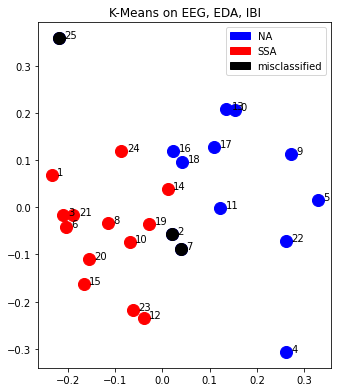

In [54]:
# Compute K-Means clustering
kmeans_result = Results(mat=mat)
kmeans = KMeans(n_clusters=2,n_init=100)
kmeans_result.applyMethod(kmeans)

# Show results
kmeans_result.twoClustersMethodResult()
kmeans_result.showResultMap()

#

#

#

#

#


## Test rendering with pandas

In [10]:
break
import pandas as pd
from pandas_profiling import ProfileReport

df = pd.DataFrame(
    np.random.rand(100, 5),
    columns=["a", "b", "c", "d", "e"]
)
profile = ProfileReport(df, title='Pandas Profiling Report')
profile.to_widgets()

SyntaxError: 'break' outside loop (<ipython-input-10-214cc6304ca6>, line 4)

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(24)
df = pd.DataFrame({'A': np.linspace(1, 10, 10)})
df = pd.concat([df, pd.DataFrame(np.random.randn(10, 4), columns=list('BCDE'))],
               axis=1)
df.iloc[3, 3] = np.nan
df.iloc[0, 2] = np.nan


In [ ]:
df.style